In [2]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.cosmology import default_cosmology
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import lenstronomy_sim, survey_sim, gs

In [3]:
pickle_path = os.path.join(config.machine.dir_00, 'detectable_gglenses_0001_sca02.pkl')  # detectable_gglenses_01
detectable_gglenses = util.unpickle(pickle_path)

print(f'{len(detectable_gglenses)} detectable lens(es)')

13 detectable lens(es)


In [58]:
band = 'F129'

sample_gglens = np.random.choice(detectable_gglenses)
# sample_gglens = detectable_gglenses[0]
sample_lens = lens_util.slsim_lens_to_mejiro(sample_gglens, bands=[band], cosmo=default_cosmology.get())

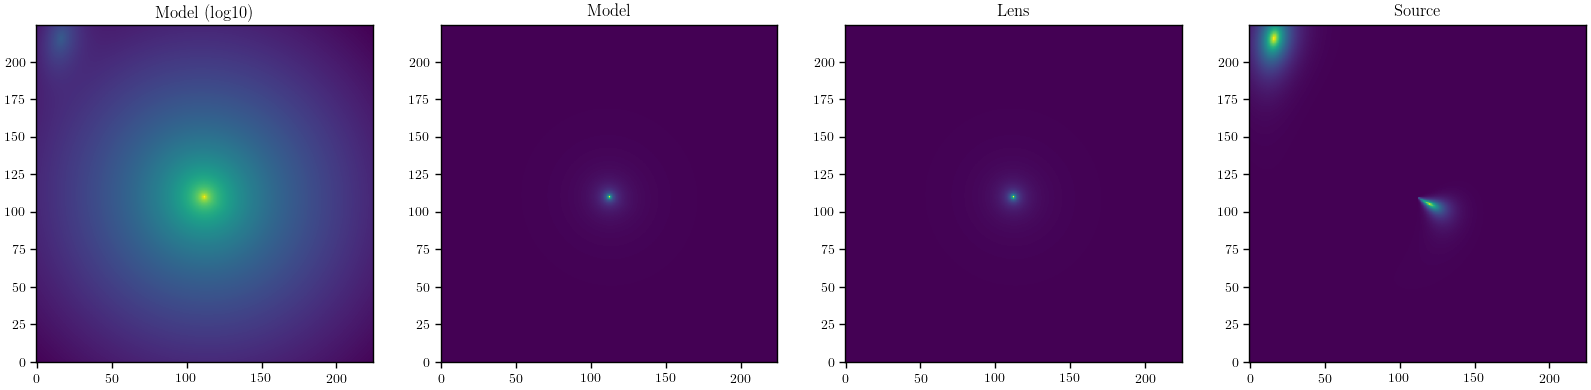

In [76]:
model, lens_sb, source_sb = sample_lens.get_array(45 * 5, 4.95, band, return_pieces=True)

f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(model))
ax[0].set_title('Model (log10)')
ax[1].imshow(model)
ax[1].set_title('Model')
ax[2].imshow(lens_sb)
ax[2].set_title('Lens')
ax[3].imshow(source_sb)
ax[3].set_title('Source')
plt.show()

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_5.pkl


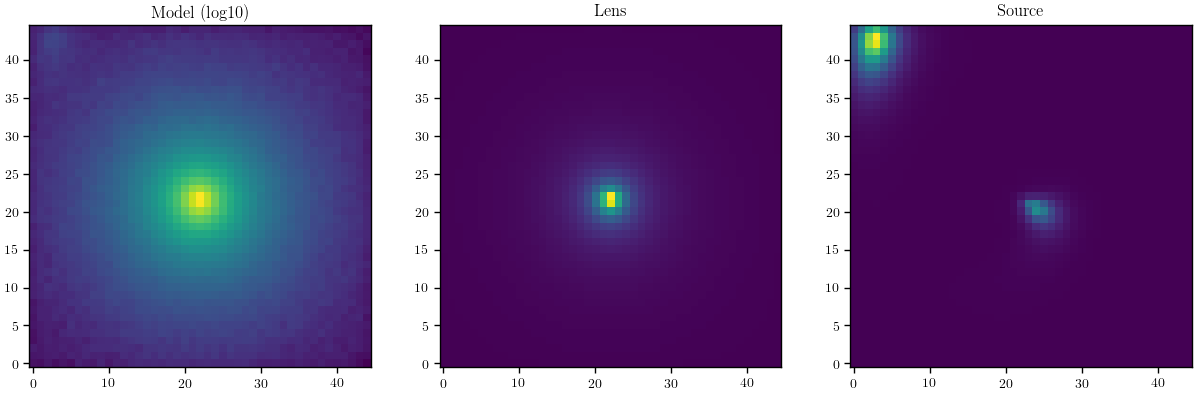

Execution time: 0:00:01


In [77]:
results, lenses, sources, execution_time = gs.get_images(sample_lens, [model], [band], 45, 45, 5, 5,
                                                         lens_surface_brightness=[lens_sb],
                                                         source_surface_brightness=[source_sb], detector=1,
                                                         detector_pos=(2048, 2048),
                                                         exposure_time=146, ra=30, dec=-30, seed=42, validate=False,
                                                         suppress_output=False, check_cache=True)

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(results[0]))
ax[0].set_title('Model (log10)')
ax[1].imshow(lenses[0])
ax[1].set_title('Lens')
ax[2].imshow(sources[0])
ax[2].set_title('Source')
plt.show()

print(f'Execution time: {execution_time}')

In [78]:
# put back into units of counts
total = results[0] * 146
lens = lenses[0] * 146
source = sources[0] * 146

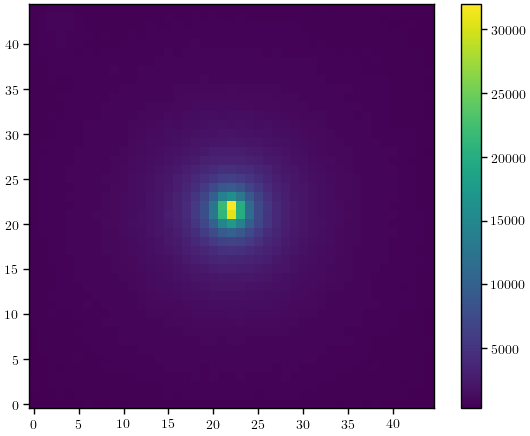

In [79]:
plt.imshow(total)
plt.colorbar()
plt.show()

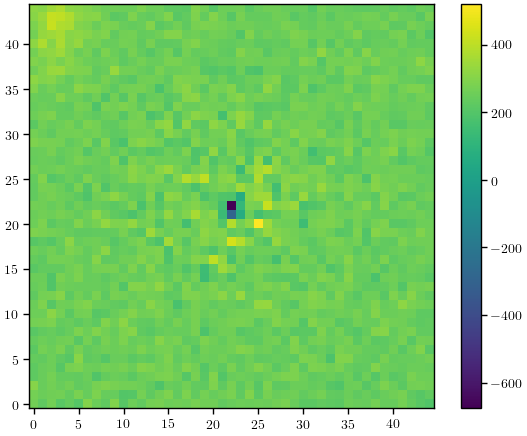

In [80]:
noise = total - (lens + source)

plt.imshow(noise)
plt.colorbar()
plt.show()

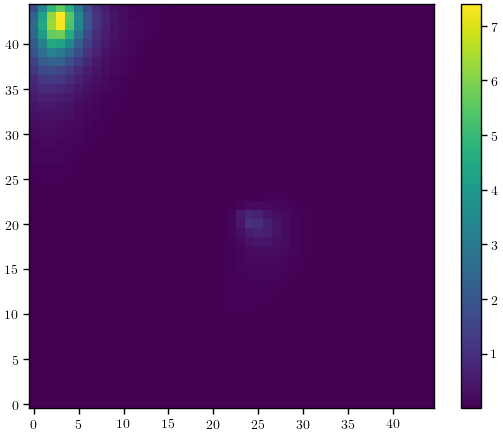

In [81]:
snr_array = source / np.sqrt(total)

plt.imshow(snr_array)
plt.colorbar()
plt.show()

In [82]:
snr_cutoff = 0.5

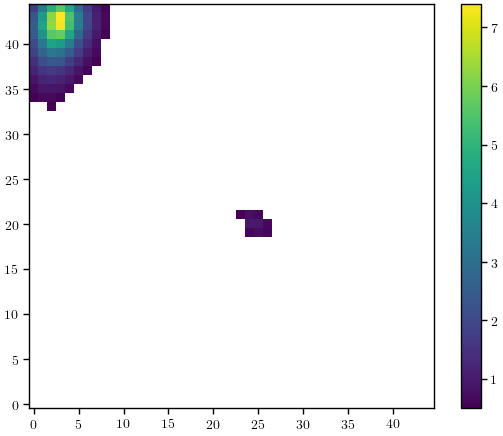

In [83]:
regions = np.ma.masked_where(snr_array <= snr_cutoff, snr_array)

plt.imshow(regions)
plt.colorbar()
plt.show()

In [84]:
if np.any(snr_array > snr_cutoff):
    print(f'There are regions with SNR > {snr_cutoff}')
else:
    print(f'There are no regions with SNR > {snr_cutoff}')

There are regions with SNR > 0.5


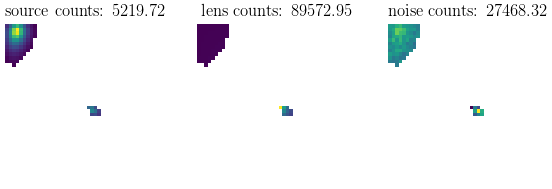

In [85]:
# mask source
masked_source = np.ma.masked_where(snr_array <= snr_cutoff, source)
source_counts = masked_source.compressed().sum()

# mask lens
masked_lens = np.ma.masked_where(snr_array <= snr_cutoff, lens)
lens_counts = masked_lens.compressed().sum()

# mask noise
masked_noise = np.ma.masked_where(snr_array <= snr_cutoff, noise)
noise_counts = masked_noise.compressed().sum()

f, ax = plt.subplots(1, 3)
ax[0].imshow(masked_source)
ax[0].set_title(f'source counts: {source_counts:.2f}')
ax[0].axis('off')
ax[1].imshow(masked_lens)
ax[1].set_title(f'lens counts: {lens_counts:.2f}')
ax[1].axis('off')
ax[2].imshow(masked_noise)
ax[2].set_title(f'noise counts: {noise_counts:.2f}')
ax[2].axis('off')
plt.show()

In [86]:
# calculate estimated SNR
snr = source_counts / np.sqrt(source_counts + lens_counts + noise_counts)
print(f'SNR: {snr}')

SNR: 14.928057670593262


In [87]:
indices = np.transpose(np.nonzero(masked_source))

numerator, denominator = 0, 0
for i, j in indices:
    numerator += masked_source[i, j]
    denominator += masked_source[i, j] + masked_lens[i, j] + masked_noise[i, j]

snr = numerator / np.sqrt(denominator)
print(f'SNR: {snr}')

SNR: 14.928056829994777


In [88]:
# np.set_printoptions(threshold=sys.maxsize)
# print(masked_source.mask)

In [89]:
regions = []
already_checked = set()

for i, j in np.transpose(np.nonzero(masked_source)):
    region = set()

    # check left neighbor
    if j != 0 and not masked_source.mask[i, j - 1]:
        region.add((i, j - 1))
    # else:
    #     to_check.add((i, j - 1))
    # check right neighbor
    if j != masked_source.shape[0]:
        region.add((i, j + 1))
    # else:
    #     to_check.add((i, j + 1))
    # check bottom neighbor
    if i != 0 and not masked_source.mask[i - 1, j]:
        region.add((i - 1, j))
    # else:
    #     to_check.add((i - 1, j))
    # check top neighbor
    if i != masked_source.shape[1]:
        region.add((i + 1, j))
    # else:
    #     to_check.add((i + 1, j))

    # TODO should move on to one of the neighbors instead of the next nonzero element, so that I can stay within one region and define it before moving on to the next region. something needs to prevent me from defining a region prematurely

    # if all neighbors have already been checked, append region and go on to defining next region
    regions.append(region)

In [90]:
print(len(regions))

92


In [184]:
# Program to count islands in boolean 2D matrix
class Graph:

    def __init__(self, row, col, g):
        self.ROW = row
        self.COL = col
        self.graph = g

    # A function to check if a given cell
    # (row, col) can be included in DFS
    def is_safe(self, i, j, visited):
        # row number is in range, column number
        # is in range and value is 1
        # and not yet visited
        return (i >= 0 and i < self.ROW and
                j >= 0 and j < self.COL and
                not visited[i][j] and self.graph[i][j])

    # A utility function to do DFS for a 2D
    # boolean matrix. It only considers
    # the 8 neighbours as adjacent vertices

    def DFS(self, i, j, visited):
        rowNbr = [-1, 1, 0, 0]
        colNbr = [0, 0, -1, 1]

        # Mark this cell as visited
        visited[i][j] = True

        # Recur for all connected neighbours
        for k in range(4):
            if self.is_safe(i + rowNbr[k], j + colNbr[k], visited):
                self.DFS(i + rowNbr[k], j + colNbr[k], visited)

        return np.where(visited)

    # The main function that returns
    # count of islands in a given boolean
    # 2D matrix

    def get_islands(self):
        regions = []
        visited = [[False for j in range(self.COL)] for i in range(self.ROW)]

        for i in range(self.ROW):
            for j in range(self.COL):
                # If a cell with value 1 is not visited yet,
                # then new island found
                if visited[i][j] == False and self.graph[i][j] != 0:
                    # Visit all cells in this island
                    # and increment island count
                    region = self.DFS(i, j, visited)
                    regions.append(region)

        return regions, visited

In [204]:
graph = [[1, 1, 0, 0, 0],
         [0, 1, 0, 0, 1],
         [1, 0, 0, 1, 1],
         [0, 0, 0, 0, 0],
         [1, 0, 1, 0, 1]]

row = len(graph)
col = len(graph[0])

g = Graph(row, col, graph)

regions, visited = g.get_islands()

pprint(regions)


def already_present(coordinates_to_check, indices_list):
    for region in indices_list:
        if coordinates_to_check in region:
            return True
    return False


from copy import deepcopy

indices_list = []
previous = None
for i, region in enumerate(regions):
    print(f'iteration {i}')
    x_coords = region[0]
    y_coords = region[1]
    og_indices = list(zip(x_coords, y_coords))
    print(f'    non-truncated indices are {og_indices}')

    new_region = []
    # identify any new coordinates: these are the coordinates of the new region
    for coordinates in og_indices:
        if not already_present(coordinates, indices_list):
            new_region.append(coordinates)

    indices_list.append(new_region)

print(indices_list)


[(array([0, 0, 1]), array([0, 1, 1])),
 (array([0, 0, 1, 1, 2, 2]), array([0, 1, 1, 4, 3, 4])),
 (array([0, 0, 1, 1, 2, 2, 2]), array([0, 1, 1, 4, 0, 3, 4])),
 (array([0, 0, 1, 1, 2, 2, 2, 4]), array([0, 1, 1, 4, 0, 3, 4, 0])),
 (array([0, 0, 1, 1, 2, 2, 2, 4, 4]), array([0, 1, 1, 4, 0, 3, 4, 0, 2])),
 (array([0, 0, 1, 1, 2, 2, 2, 4, 4, 4]), array([0, 1, 1, 4, 0, 3, 4, 0, 2, 4]))]
iteration 0
    non-truncated indices are [(0, 0), (0, 1), (1, 1)]
iteration 1
    non-truncated indices are [(0, 0), (0, 1), (1, 1), (1, 4), (2, 3), (2, 4)]
iteration 2
    non-truncated indices are [(0, 0), (0, 1), (1, 1), (1, 4), (2, 0), (2, 3), (2, 4)]
iteration 3
    non-truncated indices are [(0, 0), (0, 1), (1, 1), (1, 4), (2, 0), (2, 3), (2, 4), (4, 0)]
iteration 4
    non-truncated indices are [(0, 0), (0, 1), (1, 1), (1, 4), (2, 0), (2, 3), (2, 4), (4, 0), (4, 2)]
iteration 5
    non-truncated indices are [(0, 0), (0, 1), (1, 1), (1, 4), (2, 0), (2, 3), (2, 4), (4, 0), (4, 2), (4, 4)]
[[(0, 0), (0, 

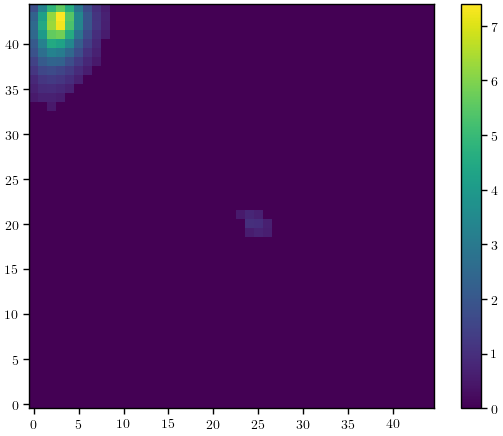

In [205]:
masked_snr_array = np.ma.masked_where(snr_array <= snr_cutoff, snr_array).filled(0)

plt.imshow(masked_snr_array)
plt.colorbar()
plt.show()

In [206]:
print(masked_snr_array.shape)

(45, 45)


In [207]:
snr_list = masked_snr_array.tolist()

row = masked_snr_array.shape[0]
col = masked_snr_array.shape[1]

g = Graph(row, col, snr_list)

regions, visited = g.get_islands()

indices_list = []
previous = None
for i, region in enumerate(regions):
    print(f'iteration {i}')
    x_coords = region[1]
    y_coords = region[0]
    og_indices = list(zip(x_coords, y_coords))
    print(f'    non-truncated indices are {og_indices}')

    new_region = []
    # identify any new coordinates: these are the coordinates of the new region
    for coordinates in og_indices:
        if not already_present(coordinates, indices_list):
            new_region.append(coordinates)

    indices_list.append(new_region)

print(indices_list)

iteration 0
    non-truncated indices are [(24, 19), (25, 19), (26, 19), (24, 20), (25, 20), (26, 20), (23, 21), (24, 21), (25, 21)]
iteration 1
    non-truncated indices are [(24, 19), (25, 19), (26, 19), (24, 20), (25, 20), (26, 20), (23, 21), (24, 21), (25, 21), (2, 33), (0, 34), (1, 34), (2, 34), (3, 34), (0, 35), (1, 35), (2, 35), (3, 35), (4, 35), (0, 36), (1, 36), (2, 36), (3, 36), (4, 36), (5, 36), (0, 37), (1, 37), (2, 37), (3, 37), (4, 37), (5, 37), (6, 37), (0, 38), (1, 38), (2, 38), (3, 38), (4, 38), (5, 38), (6, 38), (7, 38), (0, 39), (1, 39), (2, 39), (3, 39), (4, 39), (5, 39), (6, 39), (7, 39), (0, 40), (1, 40), (2, 40), (3, 40), (4, 40), (5, 40), (6, 40), (7, 40), (0, 41), (1, 41), (2, 41), (3, 41), (4, 41), (5, 41), (6, 41), (7, 41), (8, 41), (0, 42), (1, 42), (2, 42), (3, 42), (4, 42), (5, 42), (6, 42), (7, 42), (8, 42), (0, 43), (1, 43), (2, 43), (3, 43), (4, 43), (5, 43), (6, 43), (7, 43), (8, 43), (0, 44), (1, 44), (2, 44), (3, 44), (4, 44), (5, 44), (6, 44), (7, 4

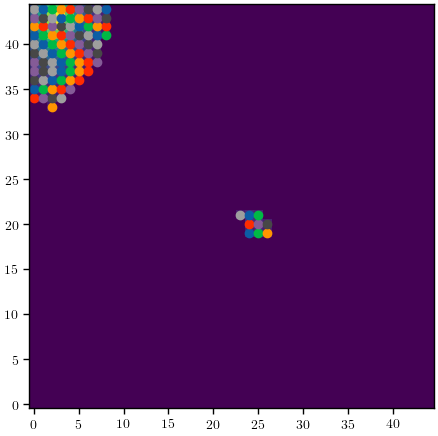

In [210]:
plt.imshow(masked_snr_array)

for region in indices_list:
    for coordinates in region:
        # print(coordinates)
        plt.scatter(coordinates[0], coordinates[1])

plt.show()